In [19]:
import pyvisa as visa
import time
import numpy as np
from pymeasure.instruments.keithley import Keithley2400
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from UtilsBasic import *
import telnet as tn

from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import AutoMinorLocator
import matplotlib.ticker as ticker

import pylab as pl
from IPython import display
N = 100000 # minimum digit 10uA
import datetime
print(datetime.datetime.now())
#from field_control import vsm_set_field, set_field, read_field
import os
rm = visa.ResourceManager()
rm.list_resources()

def connect(address, name=None, logs=None):
    rm = visa.ResourceManager()
    if address is None:
        return None
    else:
        try:
            if not name:
                device = rm.open_resource(address)
                if logs:
                    logs.add("{}:  {}".format(address, device.query("*IDN?").strip()))

                print(device.query("*IDN?"))
            else:
                device = Keithley2400(address)
                if logs:
                    logs.add("{}:  {}".format(address, device.id.strip()))

                print(device.id)
                # check connection
            return device
        except Exception as e:
            if logs:
                logs.add("error: {}".format(e))
            print(e)
            return None

from UtilsPPMS import *
ppms = Dynacool('192.168.0.7')
ppms.setField(0)
ppms.setTemperature(300)
ppms.waitForField()
ppms.waitForTemperature()
switch=tn.telnet('192.168.0.8')

2023-04-17 16:10:09.512024
Telnet connection to LinkBone has been established!


In [20]:
def plotSMRSwitch(file_name):
    #Plot current data
    hlength = 0
    with open(file_name) as myFile:
        for num, line in enumerate(myFile, 1):
            if 'angle' in line:
                hlength = num-1
            if 'fields (Oe):' in line:
                measfieldsstr=line.split(':')[1].split(',')
                measfields=[int(x) for x in measfieldsstr]
            if 'switch ports:' in line:
                switchports=line.split(':')[1].split('\n')[0].split(',')
            if 'measurement names:' in line:
                measnames=line.split(':')[1].split('\n')[0].split(',')
                if len(measnames) != len(switchports):
                    measnames=switchports

    df = pd.read_csv(file_name, header=hlength)
    #print(df)
    plt.clf()
    numfields=len(measfields)
    numswitches=len(switchports)
    for measname in measnames:
        cols = [label for label in df.columns if any(x in label for x in [measname+'_V', 'angle', 'temp','dc_current'])]
        sdf=df[cols]
        fig,ax=plt.subplots()

        plt.suptitle(file_name.split('/')[-1][:-4]+'_'+measname)
        for i in range(numfields):
            ax.plot(sdf.iloc[:,0],sdf.iloc[:,i+3]/sdf.iloc[:,2], linestyle='-',marker='o', markersize='2',linewidth=1, label=sdf.columns[i+3])
        ax.ticklabel_format(useOffset=False)
        ax.set_xlabel('Angle(deg)')
        ax.set_ylabel('$\Omega$')

        plt.tick_params(direction='in', which='both', right=True, top=True)
        #plt.tick_params(which='major', length=6)
        #plt.tick_params(which='minor', length=3)
        plt.gca().xaxis.set_minor_locator(ticker.AutoMinorLocator())
        plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator())
        #plt.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        #plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
        plt.rcParams['font.family'] = "Arial"    
        ax.legend()
        fig.savefig(file_name[:-4]+str(i)+'_'+measname+'.png', dpi=600)
#plotSMRSwitch('./data/PPMS_SMR/LSC699_Au(80)_Cr(5)_Pt(1.9)_Fe2O3(15)_Al2O3(0001)_3x3_6W1.7L/0316_2210_.csv')

In [21]:
dc_2400_id = 15
nanovolt_id = 17

dc = Keithley2400("GPIB::{}".format(dc_2400_id))
volt = rm.open_resource('GPIB0::{}::INSTR'.format(nanovolt_id))
#switch=tn.telnet('192.168.0.8')
ppms = Dynacool('192.168.0.7')

def measure_resistance(dc, volt, dc_current=100e-6, measure_points=30, skip_points=5, time_per_point=0.1):
    dc.apply_current()  # Sets up to source current
    dc.source_current_range = 10e-3   # Sets the source current range to 10 mA
    dc.compliance_voltage = 20        # Sets the compliance voltage to 10 V
    dc.source_current = dc_current            # Sets the source current to 0 mA
    dc.enable_source() 
    time.sleep(6)
    v_up = []
    for i in range(30):  # apply positive current
        time.sleep(time_per_point)
        if i < skip_points:
            continue
        v_up.append(float(volt.query("fetch?")))
    v_up = sorted(v_up)
    v_up = v_up[3: -3]
    dc.source_current = -1 * dc_current
    dc.enable_source() 
    
    v_down = []
    for i in range(measure_points):   # apply negative current
        time.sleep(time_per_point)
        if i < skip_points:
            continue
        v_down.append(float(volt.query("fetch?")))
    
    dc.shutdown() 
    
    v_down = sorted(v_down)
    v_down = v_down[3: -3]
    
    average_v = (np.array(v_up).mean() - np.array(v_down).mean())/2
    std_v = (np.array(v_up).std() + np.array(v_down).std())/2
    return average_v, std_v

def VoltMeasWithInputAnglesSwitch(angles, measfields, switchports, sample_id='',dc_current=1e-4, wait_after_hall=2, note='',
                           dc=dc,volt=volt, ppms=ppms, switch=switch, longnote='',set_temp=300, measnames=[]):
    ppms.setTemperature(set_temp)
    ppms.waitForTemperature()
    switch.sendCommand('reset')
    time.sleep(300)
    name = "data/PPMS_SMR/"+sample_id+"/{}_{}".format(time.strftime("%m%d_%H%M", time.localtime()),note)
    file_name = name+".csv"
    try:
        os.mkdir("data/PPMS_SMR/"+sample_id)
    except OSError:
        pass
    
    with open(file_name, 'a') as f:
        f.write("sample id:{}\nnote:{}\ndc current(A):{}\nwait after hall(s):{}\nswitch ports:{}\nfields (Oe):{}\ntemp(K):{}\nmeasurement names:{}\n".format(
            sample_id,longnote,dc_current,wait_after_hall,','.join(switchports),','.join(str(x) for x in measfields),set_temp,','.join(measnames)))
        if len(measnames)==len(switchports):
            colnames=measnames
        else:
            colnames=switchports
        fullcolnames=[]
        for measfield in measfields:
            for colname in colnames:
                for x in ['V','std_V']:
                    fullcolnames.append('{}_{}_{:.1f}T'.format(colname,x,measfield/10000))
        f.write("angle(deg),temp(K),dc_current(A),{}\n".format(','.join(fullcolnames)))
        
    for angle in angles:
        ppms.setPosition(angle)
        ppms.waitForPosition()
        ang=ppms.getPosition()
        ppms.setTemperature(set_temp)
        ppms.waitForTemperature()
        readtemp=ppms.getTemperature()[1]
        vlist=[]
        for field in measfields:
            ppms.setField(field)
            ppms.waitForField()
            for switchport in switchports:
                switch.sendCommand('on {},{}'.format(switchport[0],switchport[1]))
                time.sleep(0.5)
                average_v,std_v=measure_resistance(dc,volt,dc_current=dc_current)
                vlist.append(average_v)
                vlist.append(std_v)
                time.sleep(wait_after_hall)
                switch.sendCommand('reset')
        
        with open(file_name, 'a') as f:
            f.write('{},{},{},{}\n'.format(ang,readtemp,dc_current,','.join(str(x) for x in vlist)))
        display.clear_output(wait=True)
        plotSMRSwitch(file_name)
        plt.show()
        

In [15]:
switch=tn.telnet('192.168.0.8')
time.sleep(0.5)
switch.sendCommand('reset')
for ch in ['a','b','c','d','e','f']:
    time.sleep(0.2)
    switch.sendCommand('on o,{}'.format(ch))

ppms.setPosition(0)
ppms.setField(0)
ppms.waitForPosition()
ppms.waitForField

Telnet connection to LinkBone has been established!

Done.

Done.

Done.

Done.

Done.

Done.

Done.



<bound method Dynacool.waitForField of <UtilsPPMS.Dynacool object at 0x0000015E319E0470>>

In [28]:
switch=tn.telnet('192.168.0.8')
switch.sendCommand('reset')

ConnectionAbortedError: [WinError 10053] An established connection was aborted by the software in your host machine

<Figure size 640x480 with 0 Axes>

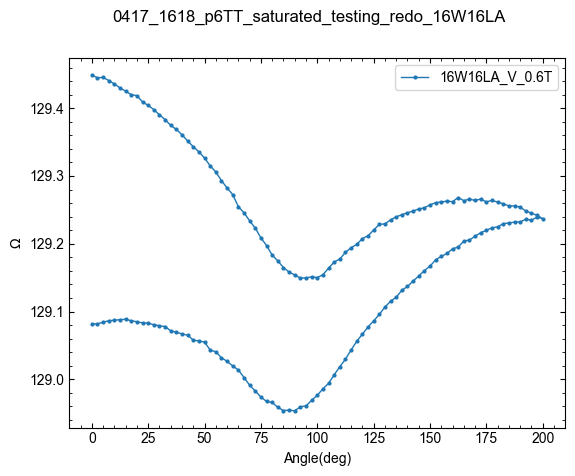

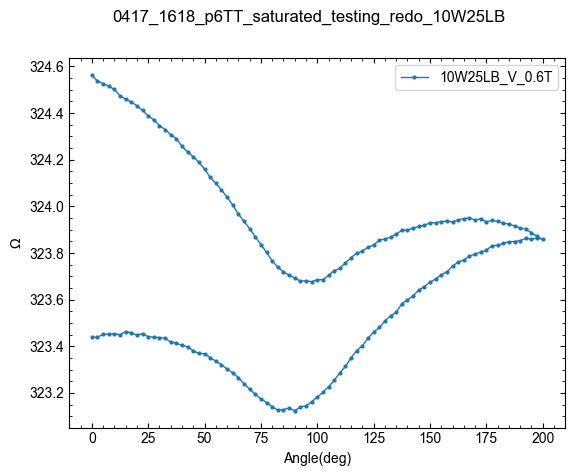

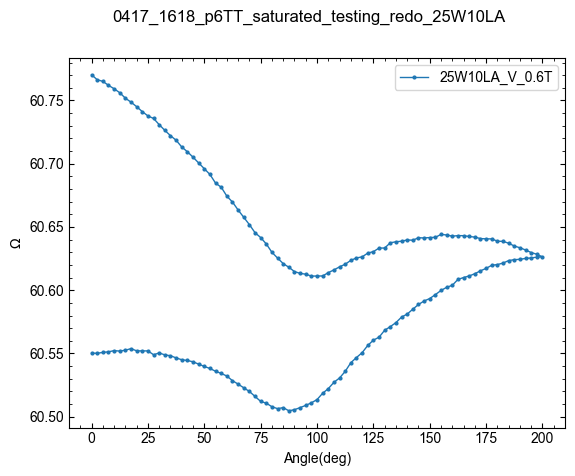

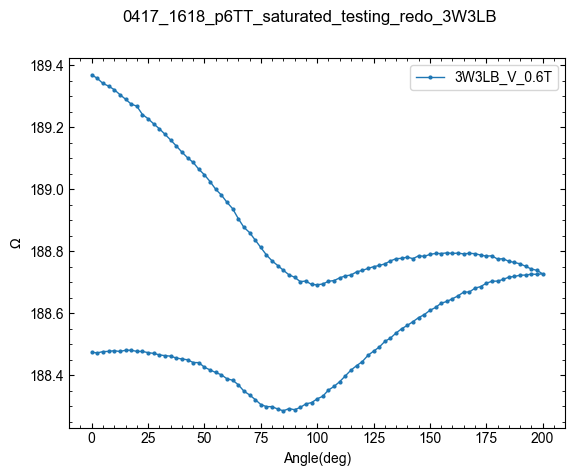

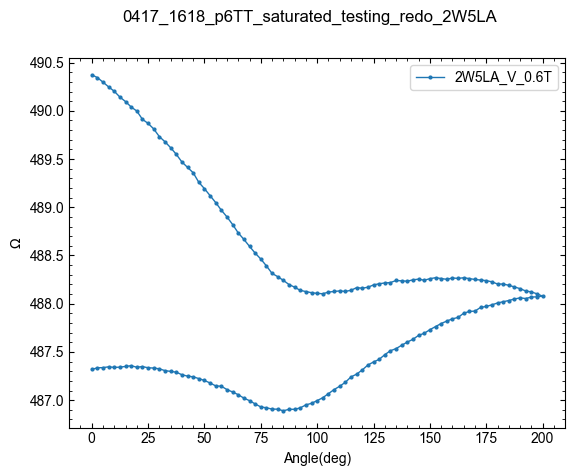

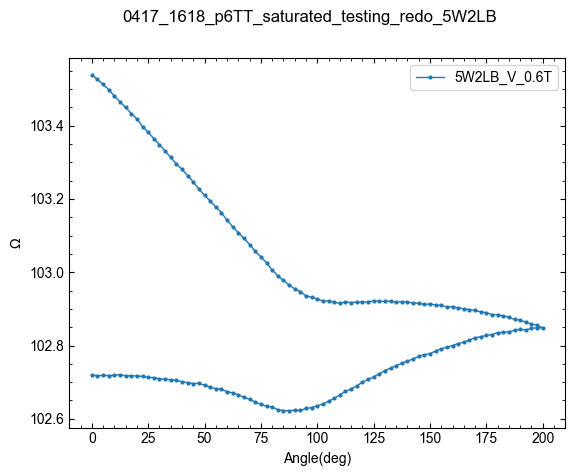

In [29]:
switch=tn.telnet('192.168.0.8')
sample_id='XE329A_Au(80)_Cr(5)_Pt(2.5)_Fe2O3(1h)_Al2O3(0001)'
angles=createArraywithSteps([0,200,0],[2.5,-2.5])
measfields=[6000]
switchports=['ma','mb','mc','md','me','mf']
measnames=['16W16LA','10W25LB','25W10LA','3W3LB','2W5LA','5W2LB']
note='p6TT_saturated_testing_redo'
longnote='''Got weird results. Redid wiring and checked again with smaller step. Wait 5 minutes before starting.
Check resistances and SMR behavior.
-'''
VoltMeasWithInputAnglesSwitch(angles, measfields, switchports, sample_id=sample_id,dc_current=1e-4, wait_after_hall=2,note=note,
                           dc=dc,volt=volt, ppms=ppms, switch=switch, longnote=longnote,set_temp=300, measnames=measnames)

<Figure size 640x480 with 0 Axes>

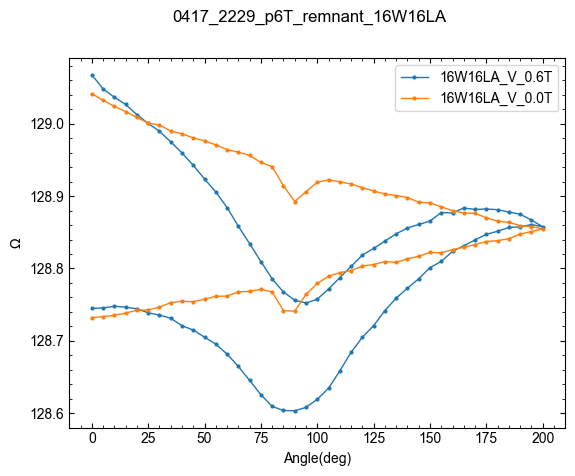

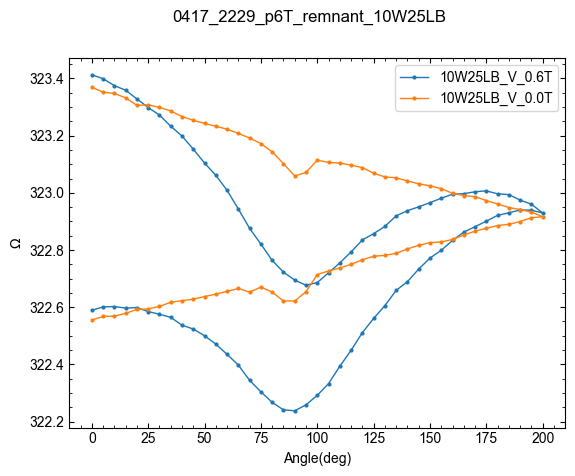

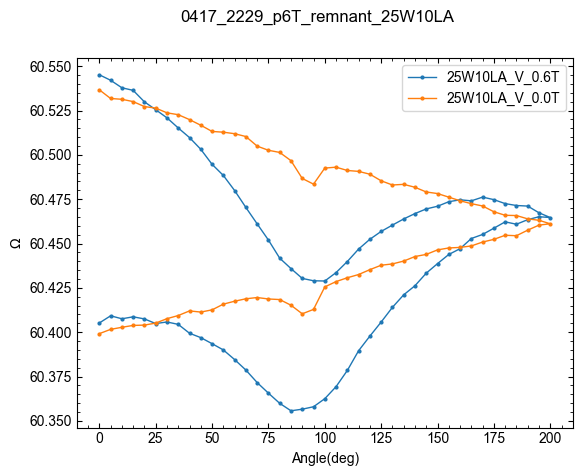

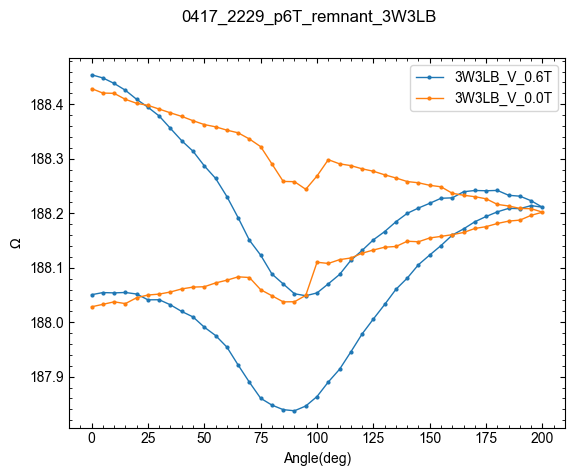

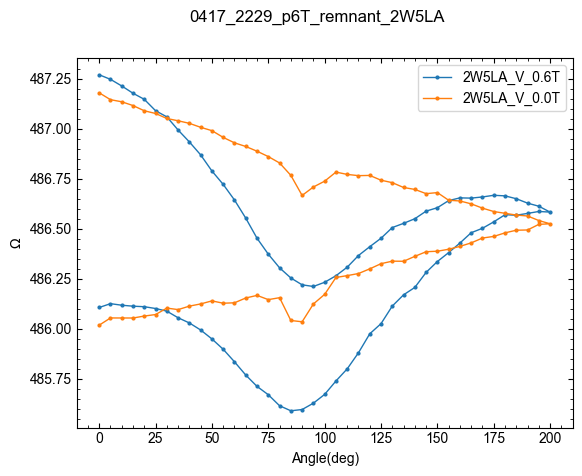

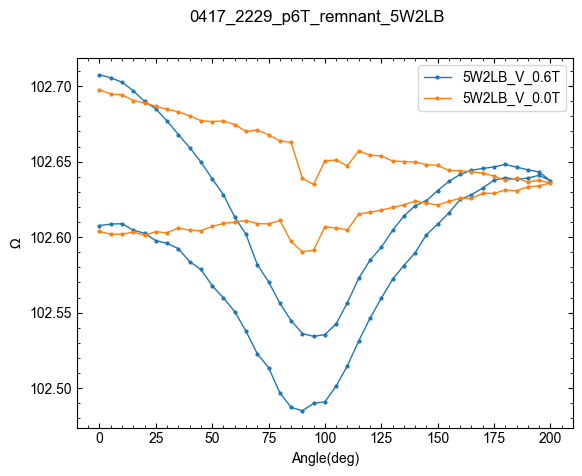

In [31]:
switch=tn.telnet('192.168.0.8')
sample_id='XE329A_Au(80)_Cr(5)_Pt(2.5)_Fe2O3(1h)_Al2O3(0001)'
angles=createArraywithSteps([0,200,0],[5,-5])
measfields=[6000,0]
switchports=['ma','mb','mc','md','me','mf']
measnames=['16W16LA','10W25LB','25W10LA','3W3LB','2W5LA','5W2LB']
note='p6T_remnant'
longnote='''Check remnant
Got weird results. Redid wiring and checked again with smaller step. Wait 5 minutes before starting.
Check resistances and SMR behavior.
-'''
VoltMeasWithInputAnglesSwitch(angles, measfields, switchports, sample_id=sample_id,dc_current=1e-4, wait_after_hall=2,note=note,
                           dc=dc,volt=volt, ppms=ppms, switch=switch, longnote=longnote,set_temp=300, measnames=measnames)

## List connected devices

In [29]:
rm = pyvisa.ResourceManager()
rm.list_resources()

('ASRL3::INSTR',
 'ASRL5::INSTR',
 'ASRL10::INSTR',
 'GPIB0::10::INSTR',
 'GPIB0::16::INSTR')

## Keithley 6221 AC current source
Connects to the 6221 and first outputs a pulse, followed by a sine wave

In [30]:
from UtilsKeithley6221 import *

#Test Keithley 6221 connection. If it cannot connect, check the GPIB port (specify with K6221(GPIBnum=#))
ac=K6221()
#Output a 10uA pulse
ac.pulseOut()
#Output a 10uA indefinite length sine wave
ac.sinOut()

## SR865A Lock-In Amplifier 
Connects to and reads the Lock in parameters

In [31]:
from UtilsSR865A import *
lock=Lockin()
lock.readLockin()

(6.5432664087e-07, -1.3170010789e-06, 1.2890700418e-06, -127.38214111)

In [32]:
from UtilsBasic import *
createArraywithSteps([1,10],[2])

The final array generated is  [1, 3, 5, 7, 9, 10]


[1, 3, 5, 7, 9, 10]